## ICESat-2 ATL03 SlideRule Demo

Plot ATL03 data with different classifications for a region over the Grand Mesa, CO region 

- [ATL08 Land and Vegetation Height product](https://nsidc.org/data/atl08) photon classification
- Experimental YAPC (Yet Another Photon Classification) photon-density-based classification

### What is demonstrated

* The `icesat2.atl03sp` API is used to perform a SlideRule parallel subsetting request of the Grand Mesa region
* The `earthdata.cmr` API's is used to find specific ATL03 granules corresponding to the Grand Mesa region
* The `matplotlib` package is used to plot the ATL03 data subset by SlideRule

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sliderule import sliderule, icesat2, earthdata
import geopandas as gpd
from datetime import datetime
from datetime import timedelta
import json
import math

/srv/conda/envs/notebook/lib/python3.10/site-packages/sliderule/sliderule.py:41: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas


In [3]:
url = "slideruleearth.io"
icesat2.init(url, verbose=False)
asset = "icesat2"

### Retrieve ATL03 elevations with several classification options

For two region of interest (blackrock, utqiagvik)

In [73]:
########## SET PARAMETERS ######################

###### Region of interest #########
region = "blackrock" # (blackrock, utqiagvik)


##### Read input parameters from .json files #####
poly_fn = f"../../data/bbox_{region}.geojson"

pregion = gpd.read_file(poly_fn)
poly = sliderule.toregion(pregion)["poly"]

# Opening JSON file
f = open("../../data/icesat2_tracks.json")
data = json.load(f)

granule_id = data[region]['granule_id']
track = int(data[region]['beam'][2])
pair = 0 if data[region]['beam'][3]=="l" else 1

time_start = datetime.strptime(granule_id[6:14], "%Y%m%d").strftime("%Y-%m-%d")
time_end = (datetime.strptime(granule_id[6:14], "%Y%m%d") + timedelta(days=1)).strftime("%Y-%m-%d")
rgt = int(granule_id[21:25])
cycle = int(granule_id[25:27])

########## SET PARAMETERS ######################

## Calculate ATL06-SR Elevations from ATL03 Photons using SlideRule

In [74]:
%%time

##### Set ATL03 sp parameters ##############################
# build sliderule parameters for ATL03 subsetting request
# SRT_LAND = 0
# SRT_OCEAN = 1
# SRT_SEA_ICE = 2
# SRT_LAND_ICE = 3
# SRT_INLAND_WATER = 4
parms = {
    # processing parameters
    "srt": 0,
    "len": 10,
    "res": 10,
    "track": track,
    # classification and checks
    # still return photon segments that fail checks
    "pass_invalid": True,
    # all photons
    "cnf": 0,
    "cnt": 5,
    "atl03_geo_fields": ["ref_azimuth", "ref_elev", "geoid"],
    "atl03_ph_fields": ["delta_time"],
    # all land classification flags
    # "atl08_class": ["atl08_noise", "atl08_ground", "atl08_canopy", "atl08_top_of_canopy", "atl08_unclassified"],
    # all photons
    "yapc": dict(knn=0, win_h=6, win_x=11, min_ph=4, score=0), 
}

# ICESat-2 data release
release = '006'
# region of interest

# find granule for each region of interest
granules_list = earthdata.cmr(short_name='ATL03', polygon=poly, time_start=time_start, time_end=time_end, version=release)

# create an empty geodataframe
parms["poly"] = poly
# gdf = icesat2.atl03sp(parms, asset=asset, version=release, resources=granules_list)
gdf = icesat2.atl03sp(parms, asset=asset, resources=granules_list)


CPU times: user 43 s, sys: 868 ms, total: 43.9 s
Wall time: 47.4 s


In [6]:
len(gdf)

783158

In [94]:
len(gdf)

119414

In [75]:
# Reduce dataframe for a single beam
def reduce_dataframe(gdf, RGT=None, GT=None, track=None, pair=None, cycle=None, beam='', crs=4326):
    # convert coordinate reference system
    D3 = gdf.to_crs(crs)
    # reduce to reference ground track
    if RGT is not None:
        D3 = D3[D3["rgt"] == RGT]
    # reduce to ground track (gt[123][lr]), track ([123]), or pair (l=0, r=1) 
    gtlookup = {icesat2.GT1L: 1, icesat2.GT1R: 1, icesat2.GT2L: 2, icesat2.GT2R: 2, icesat2.GT3L: 3, icesat2.GT3R: 3}
    pairlookup = {icesat2.GT1L: 0, icesat2.GT1R: 1, icesat2.GT2L: 0, icesat2.GT2R: 1, icesat2.GT3L: 0, icesat2.GT3R: 1}
    if GT is not None:
        D3 = D3[(D3["track"] == gtlookup[GT]) & (D3["pair"] == pairlookup[GT])]
    if track is not None:
        D3 = D3[D3["track"] == track]
    if pair is not None:
        D3 = D3[D3["pair"] == pair]
    # reduce to weak or strong beams
    # tested on cycle 11, where the strong beam in the pair matches the spacecraft orientation.
    # Need to check on other cycles
    if (beam == 'strong'):
        D3 = D3[D3['sc_orient'] == D3['pair']]
    elif (beam == 'weak'):
        D3 = D3[D3['sc_orient'] != D3['pair']]
    # reduce to cycle
    if cycle is not None:
        D3 = D3[D3["cycle"] == cycle]
    # otherwise, return both beams
    
    D3['x_atc'] = D3['segment_dist']+D3['distance']-np.min(D3['segment_dist'])

    # compute orthometric heights using the onboard geoid model (EGM08)
    D3['height_ortho'] = D3['height'] - D3['geoid']
    
    return D3

In [76]:
beam_type = 'strong'
project_srs = "EPSG:4326" #"EPSG:26912+EPSG:5703"
D3 = reduce_dataframe(gdf, RGT = rgt, track=track, pair = pair, beam=beam_type, crs=project_srs)

In [60]:
print(len(D3))
D3.head()

933620


,track,cycle,segment_dist,solar_elevation,background_rate,rgt,sc_orient,segment_id,atl03_cnf,yapc_score,...,landcover,ref_azimuth,ref_elev,geoid,delta_time,pair,geometry,spot,x_atc,height_ortho
time,,,,,,,,,,,,,,,,,,,,,
2022-04-17 01:15:52.821399040,1,15,1.208686e+07,23.647131,4.383076e+06,381,0,603405,0,28,...,255,-0.429723,1.567638,-1.200101,1.353934e+08,0,POINT (-156.48801 71.56400),1,-4.083188,47.466770
2022-04-17 01:15:52.821399040,1,15,1.208686e+07,23.647131,4.383076e+06,381,0,603405,1,19,...,255,-0.429723,1.567638,-1.200101,1.353934e+08,0,POINT (-156.48801 71.56399),1,-3.968743,5.093244
2022-04-17 01:15:52.821399040,1,15,1.208686e+07,23.647131,4.383076e+06,381,0,603405,4,138,...,255,-0.429723,1.567638,-1.200101,1.353934e+08,0,POINT (-156.48801 71.56399),1,-3.953404,-0.694184
2022-04-17 01:15:52.821399040,1,15,1.208686e+07,23.647131,4.383076e+06,381,0,603405,0,21,...,255,-0.429723,1.567638,-1.200101,1.353934e+08,0,POINT (-156.48801 71.56399),1,-3.667858,-106.397987
2022-04-17 01:15:52.821399040,1,15,1.208686e+07,23.647131,4.383076e+06,381,0,603405,0,0,...,255,-0.429723,1.567638,-1.200101,1.353934e+08,0,POINT (-156.48801 71.56399),1,-3.646224,-114.431114


In [89]:
D3.keys()

Index(['sc_orient', 'segment_dist', 'solar_elevation', 'background_rate',
       'cycle', 'track', 'segment_id', 'rgt', 'yapc_score', 'quality_ph',
       'height', 'atl08_class', 'landcover', 'atl03_cnf', 'relief', 'distance',
       'snowcover', 'ref_azimuth', 'ref_elev', 'geoid', 'pair', 'geometry',
       'spot', 'x_atc', 'height_ortho'],
      dtype='object')

### Plot photon confidence

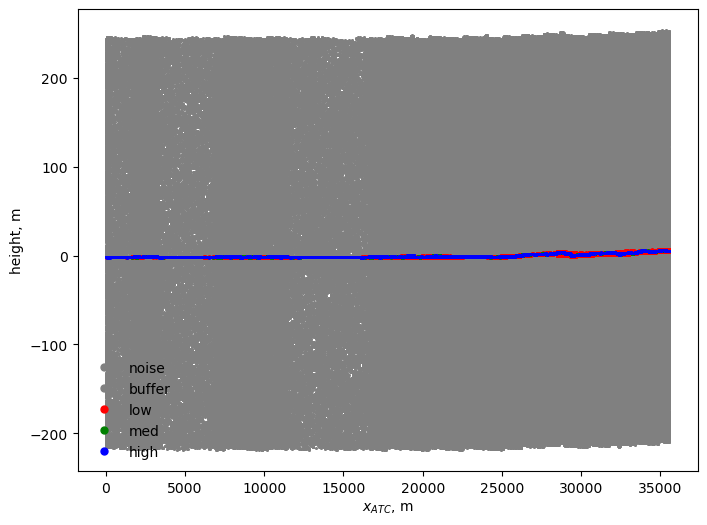

In [10]:
plt.figure(figsize=[8,6])

colors={0:['gray', 'noise'], 
        1:['gray','buffer'],  
        2:['red','low'], 
        3:['green', 'med'], 
        4:['blue', 'high']}
d0=np.min(D3['x_atc'])
for class_val, color_name in colors.items():
    ii=D3['atl03_cnf']==class_val
    plt.plot(D3['x_atc'][ii]-d0, D3['height'][ii],'o', 
         markersize=1, color=color_name[0], label=color_name[1])
hl=plt.legend(loc=3, frameon=False, markerscale=5)
# plt.gca().set_xlim([26000, 30000])
# plt.gca().set_ylim([2950, 3150])

plt.ylabel('height, m')
plt.xlabel('$x_{ATC}$, m');

### Plot the YAPC classifications

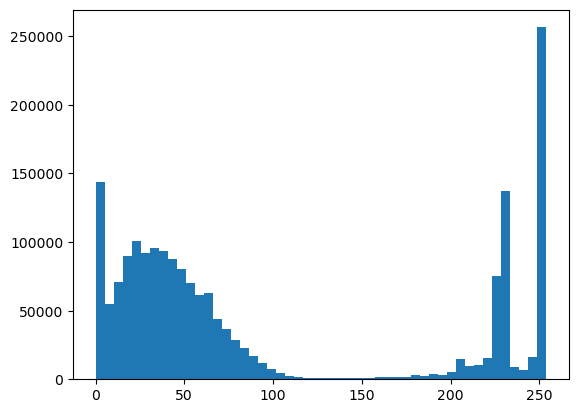

In [11]:
plt.figure()
plt.hist(D3['yapc_score'], bins = 50);

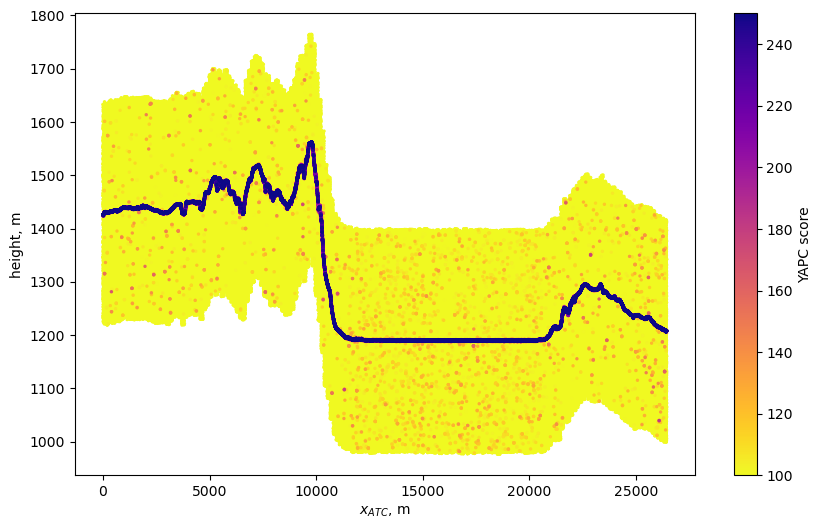

In [10]:
plt.figure(figsize=[10,6])

d0=np.min(D3['x_atc'])
ii=np.argsort(D3['yapc_score'])
plt.scatter(D3['x_atc'][ii] - d0,
    D3['height_ortho'][ii],2, c=D3['yapc_score'][ii],
    vmin=100, vmax=250,cmap='plasma_r')
plt.colorbar(label='YAPC score')
# plt.gca().set_xlim([0, 5000])
# plt.gca().set_ylim([2950, 3150])

plt.ylabel('height, m')
plt.xlabel('$x_{ATC}$, m');

In [14]:
yapc_steps = np.arange(160, 250, 10) #[180, 190, 200, 210, 220, 230, 240]

xbin = 500
x_steps = np.arange(0, 25000, xbin)

array_std = np.zeros((len(yapc_steps), len(x_steps)))
array_mean = np.zeros((len(yapc_steps), len(x_steps)))

xx, yy = np.meshgrid(x_steps+xbin/2, yapc_steps+5)

for i, x1 in enumerate(x_steps): #every 1 km
    
    for j, yapc_threshold in enumerate(yapc_steps):
        
        df = D3[(D3['x_atc'] >= x1) & (D3['x_atc'] < x1+xbin)]
        signal = df['yapc_score'] > yapc_threshold

        df = df[signal]
        hmean = np.mean(df['height_ortho'])
        hstd = np.std(df['height_ortho'])
                     
        array_mean[j, i] = hmean
        array_std[j,i ] = hstd

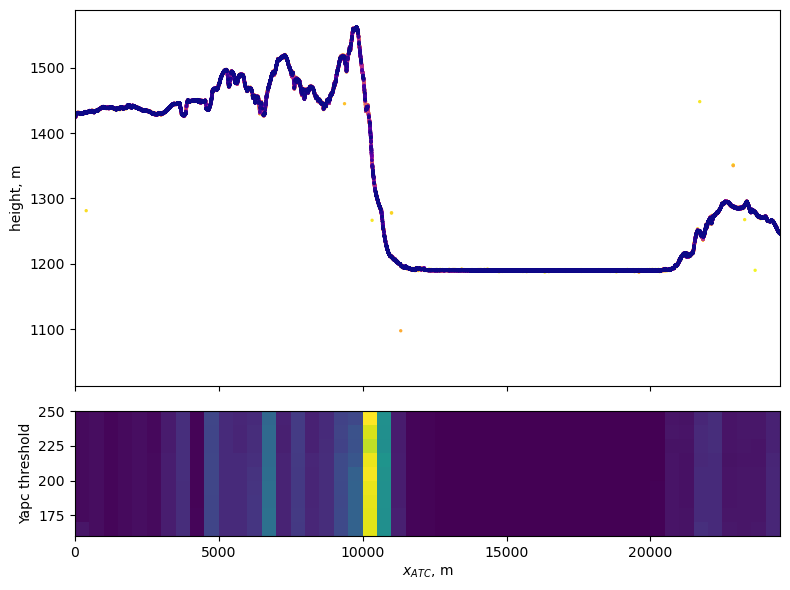

In [16]:
fig, ax = plt.subplots(2,1,figsize=[8,6], sharex = True, height_ratios=[3, 1])

yapc_threshold = 160
signal = D3['yapc_score'] > yapc_threshold

df = D3[signal]

d0=np.min(df['x_atc'])
ii=np.argsort(df['yapc_score'])
sc = ax[0].scatter(df['x_atc'][ii] - d0, df['height_ortho'][ii],2, c=df['yapc_score'][ii],
    vmin=yapc_threshold, vmax=250,cmap='plasma_r')
# fig.colorbar(sc, ax = ax[0], label='YAPC score')
ax[0].set_ylabel('height, m')
# ax[0].set_ylim(-3, 5)

ax[1].pcolormesh(xx, yy, array_std)
ax[1].set_xlabel('$x_{ATC}$, m')
ax[1].set_xlim(x_steps[0], x_steps[-1])
ax[1].set_ylabel("Yapc threshold")
plt.tight_layout()

### Calculate fitting (based on Nathan's code)

In [62]:
#Code to fit a specific surface distribution to ATL03 photon cloud

import earthaccess
from datetime import datetime
import numpy as np

#Import modules
%load_ext autoreload
%autoreload 2
import is2_model as is2m

import os

import h5py
import pdb  #python debugger
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import interpolate
from scipy.signal import find_peaks, resample, resample_poly
from scipy.optimize import curve_fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
#Set options for curve fitting and photon selection
fit_opts = {'ftol': 0.01, 'max_nfev': 500, 'xtol': 0.01}
surface_fitting_method = 'Lognormal'  #'Gaussian' or 'Lognormal'

/tmp/ipykernel_175/3662066763.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (5,3))


Done


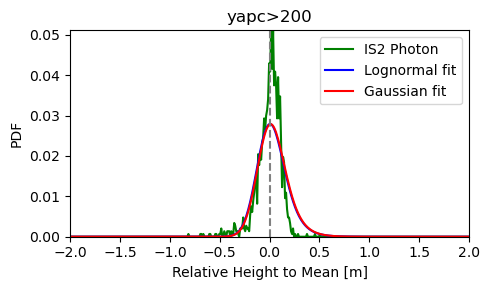

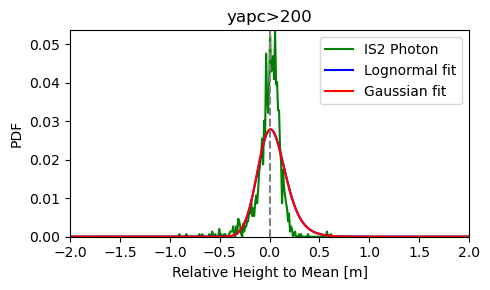

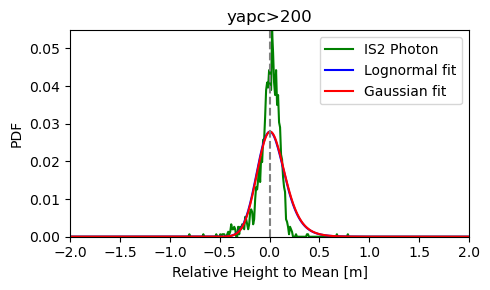

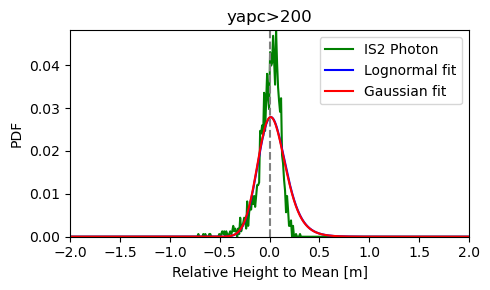

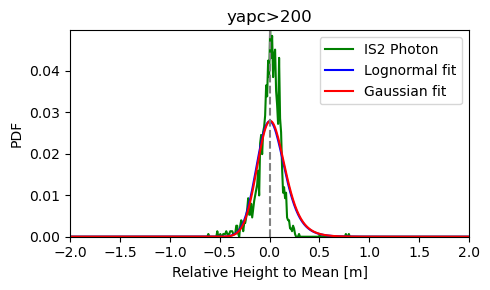

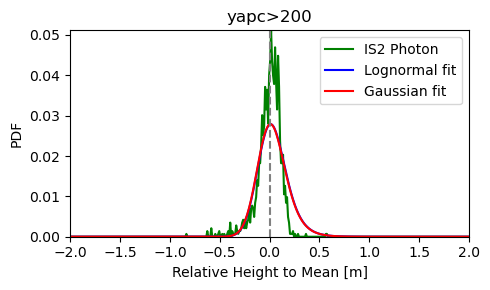

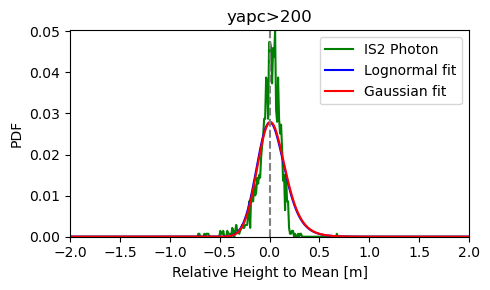

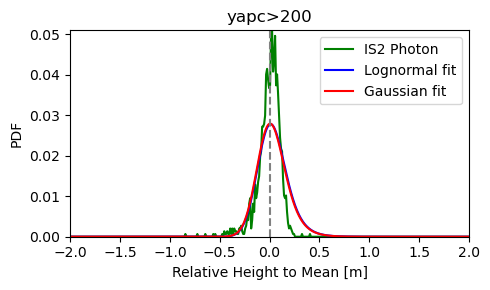

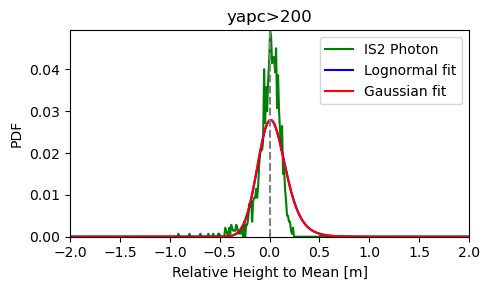

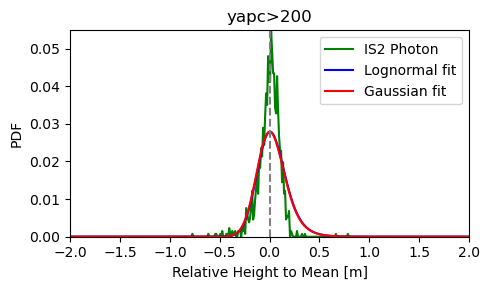

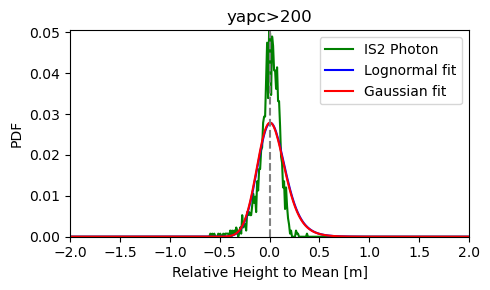

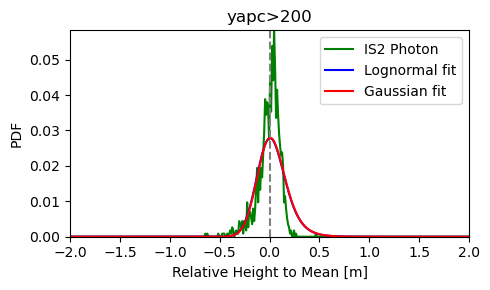

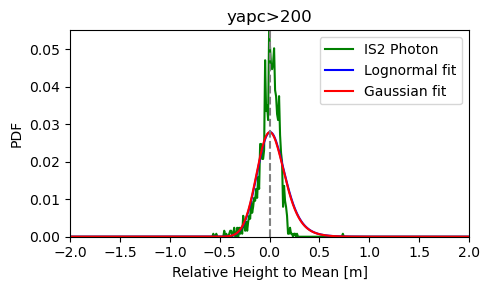

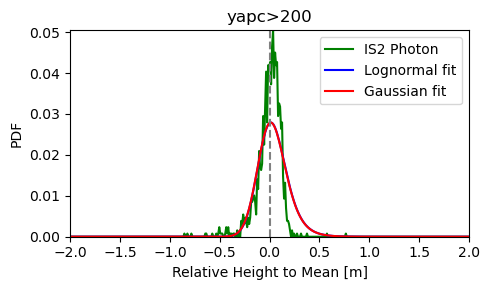

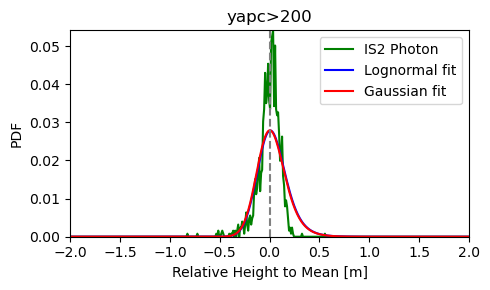

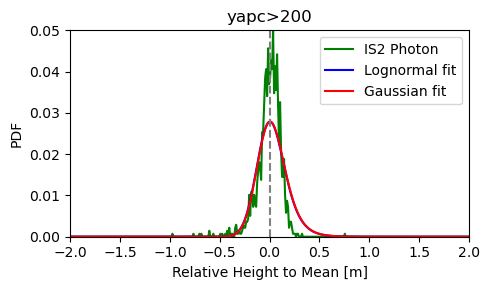

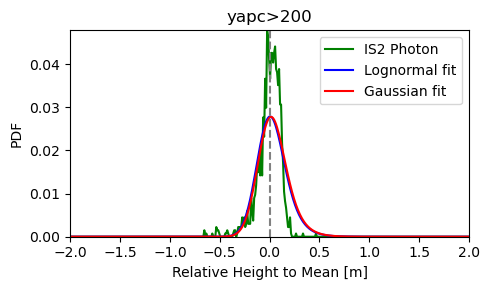

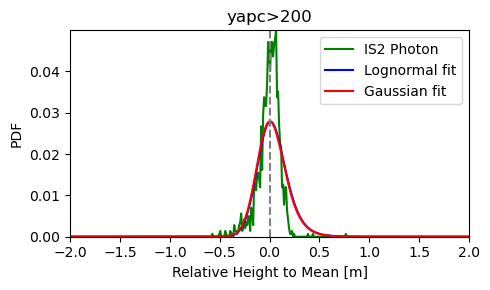

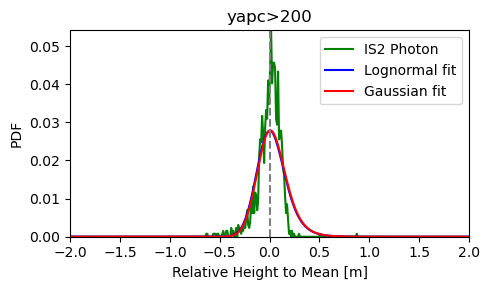

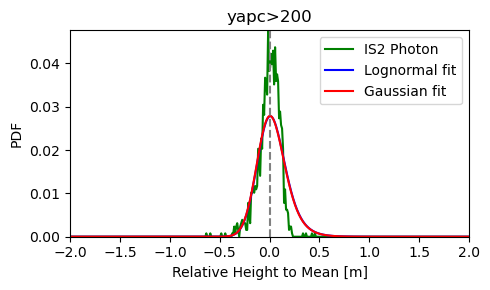

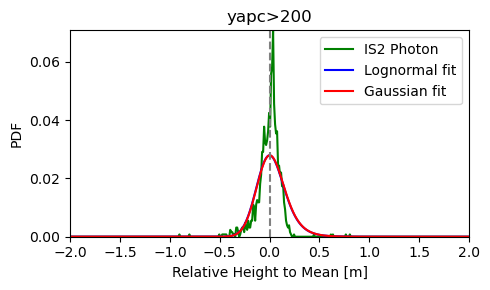

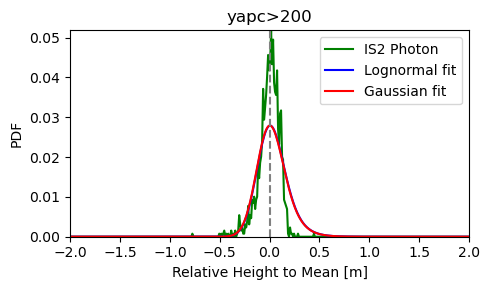

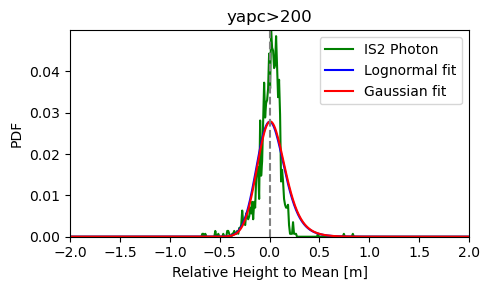

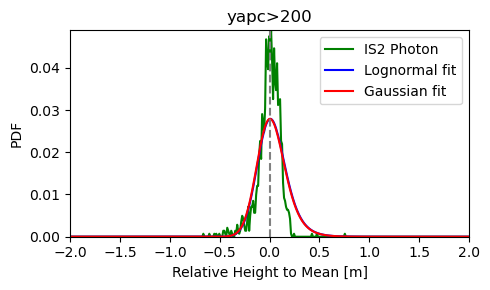

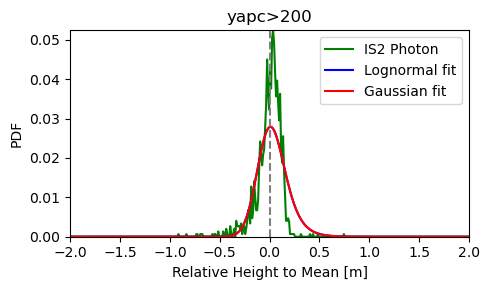

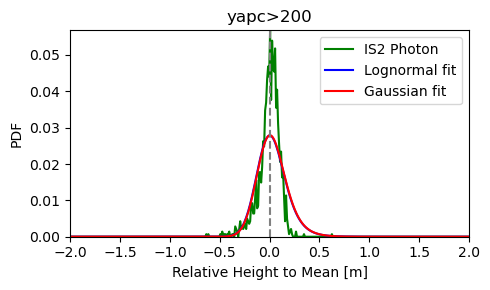

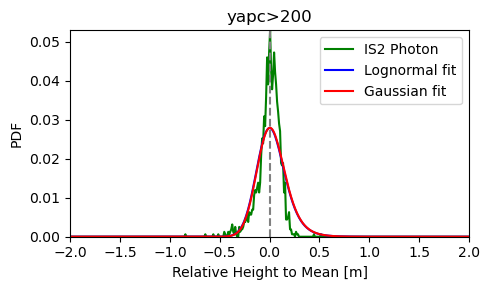

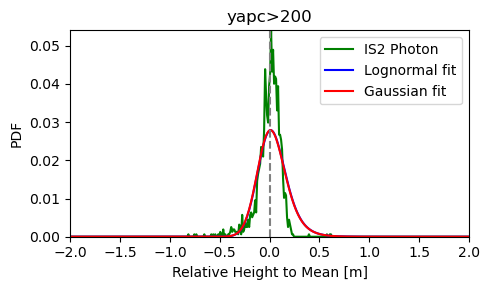

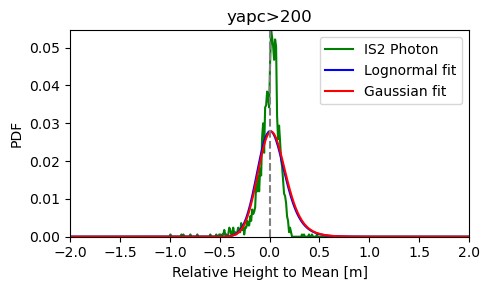

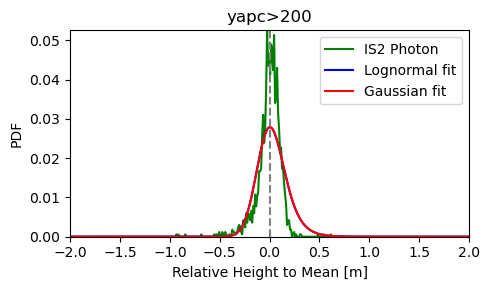

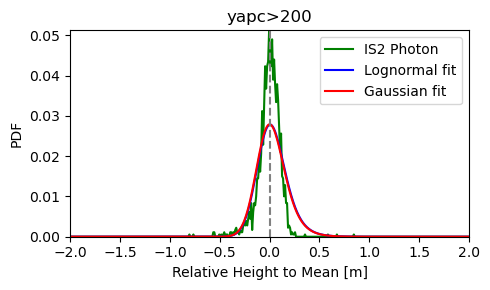

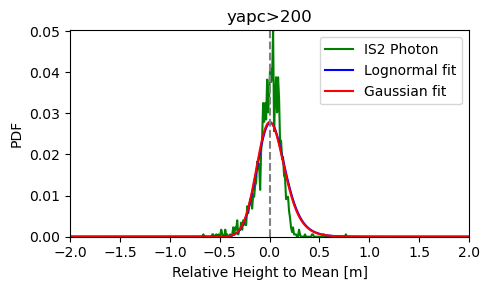

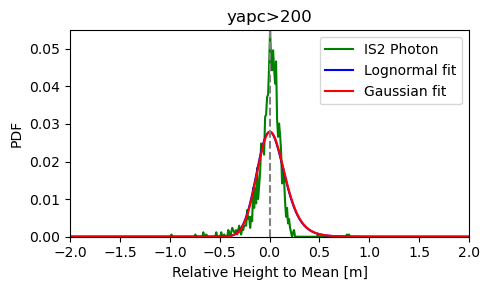

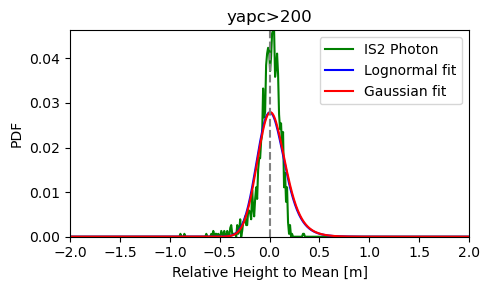

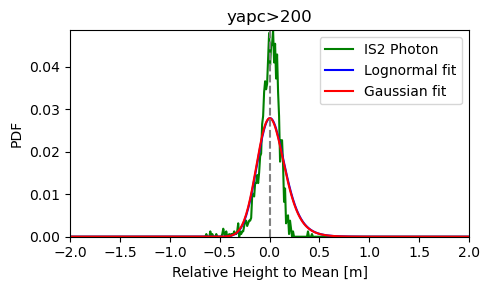

In [85]:
yapc_steps = np.arange(160, 250, 10) #[180, 190, 200, 210, 220, 230, 240]

draw = True
xbin = 200
x_steps = np.arange(13000, 20000, xbin)

xx, yy = np.meshgrid(x_steps+xbin/2, yapc_steps+5)

array_photon = np.zeros((len(yapc_steps), len(x_steps)))

array_log_retrack = np.zeros((len(yapc_steps), len(x_steps)))
array_log_sigma = np.zeros((len(yapc_steps), len(x_steps)))
array_log_err = np.zeros((len(yapc_steps), len(x_steps)))

array_normal_retrack = np.zeros((len(yapc_steps), len(x_steps)))
array_normal_sigma = np.zeros((len(yapc_steps), len(x_steps)))
array_normal_err =  np.zeros((len(yapc_steps), len(x_steps)))

for i, x1 in enumerate(x_steps): #every 1 km
    
    if draw:
        plt.figure(figsize = (5,3))
        
        folder = f"Photon_curve/{region}/bins_{xbin}"
        if os.path.exists(folder):
            pass
        else:
            os.mkdir(folder)
    
    for j, yapc_threshold in enumerate(yapc_steps):
        
        yapc_color = cmap = matplotlib.cm.get_cmap('jet')
        rgba = cmap((yapc_threshold - yapc_steps.min())/(yapc_steps.max() - yapc_steps.min()))
        
        df = D3[(D3['x_atc'] >= x1) & (D3['x_atc'] < x1+xbin)]
        signal = df['yapc_score'] > yapc_threshold

        df = df[signal]
        ph_height = df['height_ortho'].values
        ph_mean = np.mean(df['height_ortho'])
        ph_std = np.std(df['height_ortho'])
        
        ph_height = ph_height - ph_mean
        ph_mean = np.mean(ph_height)
        
        
        nrb = 500
        rb_res = 0.01
        track_point = ph_mean
        range_bins_m = np.arange(1, nrb) * rb_res - (nrb-1)/2*rb_res - ph_mean #(nrb-1)/3*rb_res  # Set range bins with 3 cm resolution
        wf = np.histogram(ph_height-ph_mean, bins=range_bins_m)
        #WF_norm_this = wf[0][:]/np.max(wf[0][:])
        WF_norm_this = wf[0][:]/np.sum(wf[0][:])
        WF_norm_this[WF_norm_this < 0] = 0
        wf_rb = wf[1][:]


        # Calculate lognormal or Gaussian fit

        range_bins_m_hr = np.arange(1, nrb*5) * rb_res/5 - (5*nrb-1)/2*rb_res/5 - ph_mean  # Set range bins with 5x rb_res cm resolution for use when generating pulse shape and distributions
        range_bins_unit = np.arange(1, nrb)

        tracker = lambda xdata, *p: is2m.is2modelfit_nonnormalized(xdata, p,range_bins_m_hr)

        rb_use = range_bins_m[0:np.size(WF_norm_this)]

        if surface_fitting_method == 'Lognormal':  
            fit_method = 1
        if surface_fitting_method == 'Gaussian':
            fit_method = 0


        x0 = np.asarray([fit_method, 0, ph_std])  # Fit method, x shift (in meters), roughness
        lb = x0 - [0.05, 0.5, 0.3]
        ub = x0 + [0.05, 0.5, 0.3]
        if lb[2] < 0:
            lb[2] = 0.005
        GSFC_optimal, GSFC_cov = curve_fit(tracker, rb_use, WF_norm_this, x0, bounds=(lb, ub), method='trf',  **fit_opts)


        GSFC_fit = is2m.is2modelfit_nonnormalized(rb_use, GSFC_optimal,range_bins_m_hr)
        # Calculate sum of squared residuals
        GSFC_resnorm = np.sum((WF_norm_this - GSFC_fit)**2)


        #####Run again with Gaussian fit
        x0g = np.asarray([0, 0, ph_std])  # Fit method, x shift (in meters), roughness
        lb[0]=0
        ub[0] = 1
        GSFC_optimal_Gaussian, GSFC_cov_Gaussian = curve_fit(tracker, rb_use, WF_norm_this, x0g, bounds=(lb, ub), method='trf',  **fit_opts)
        GSFC_fit_Gaussian = is2m.is2modelfit_nonnormalized(rb_use, GSFC_optimal_Gaussian,range_bins_m_hr)
        # Calculate sum of squared residuals
        GSFC_resnorm_Gaussian = np.sum((WF_norm_this - GSFC_fit_Gaussian)**2)
        
        ##### Make plots #############################        
        if draw:
            if yapc_threshold == 200:
                plt.plot(wf_rb[0:np.size(wf[0][:])],WF_norm_this,label=f'IS2 Photon', ls = "-", color = 'g')

                plt.plot(rb_use,GSFC_fit,label=surface_fitting_method + f' fit', ls = "-", color = 'b')

                plt.plot(rb_use,GSFC_fit_Gaussian,label='Gaussian' + f' fit', ls = "-", color = 'r')
                plt.title(f'yapc>{yapc_threshold}')

                #p2=plt.plot(rb_use+GSFC_optimal[1],WF_norm_this,'k')
                plt.plot([0,0],[0,np.max(WF_norm_this)], color = 'gray', ls = "--") #Plot 0 point which is the mean height location
                #p1 = plt.plot([1.0*GSFC_optimal[1],1.0*GSFC_optimal[1]],[0,1])  #Plot Ron's ATL07 tracking point
                plt.legend()
                plt.axis([-2, 2, 0, np.max(WF_norm_this)]) 
                plt.xlabel('Relative Height to Mean [m]')
                plt.ylabel('PDF')
                plt.tight_layout()
                plt.savefig(f"{folder}/Fitting_curve_{x1}.png")
                # plt.close()
                # plt.show()
        ####################################################
        
        array_photon[j, i] = np.size(ph_height)
        
        array_log_retrack[j,i ] = GSFC_optimal[1]
        array_log_sigma[j,i ] = GSFC_optimal[2]
        array_log_err[j,i ] = GSFC_resnorm
        
        array_normal_retrack[j,i ] = GSFC_optimal_Gaussian[1]
        array_normal_sigma[j,i ] = GSFC_optimal_Gaussian[2]
        array_normal_err[j,i ] =  GSFC_resnorm_Gaussian

        # print("N photons: ",np.size(ph_height))
        # print("Lognormal height retrack correction, lognormal sigma, fit_error: {0:.3f}, {1:.3f}, {2:.3f}".format(
        #     GSFC_optimal[1],GSFC_optimal[2], GSFC_resnorm))
        # print("Gaussian height retrack correction, Gaussian sigma, fit_error: {0:.3f}, {1:.3f}, {2:.3f}".format(
        #     GSFC_optimal_Gaussian[1],GSFC_optimal_Gaussian[2], GSFC_resnorm_Gaussian))

print("Done")

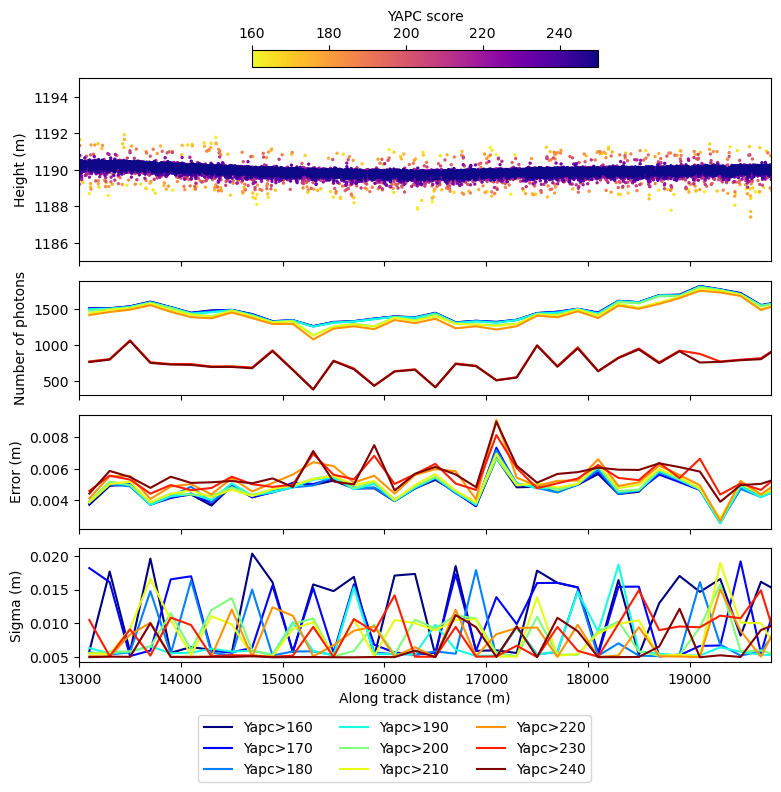

In [87]:
fig, ax = plt.subplots(4,1,figsize=[8, 8], sharex = True, height_ratios=[2, 1, 1, 1])

yapc_threshold = 160
signal = D3['yapc_score'] > yapc_threshold

df = D3[signal]

d0=np.min(df['x_atc'])
ii=np.argsort(df['yapc_score'])
sc = ax[0].scatter(df['x_atc'][ii] - d0, df['height_ortho'][ii],2, c=df['yapc_score'][ii],
    vmin=yapc_threshold, vmax=250,cmap='plasma_r')
fig.colorbar(sc, ax = ax[0], label='YAPC score', orientation = "horizontal", location = "top", shrink = 0.5)
ax[0].set_ylabel('Height (m)')
if region == "utqiagvik": # (blackrock, utqiagvik)
    ax[0].set_ylim(-3, 5) # Utqiagvik
elif region == "blackrock":
    ax[0].set_ylim(1185, 1195) # Blackrock

for j, yapc_threshold in enumerate(yapc_steps):
    yapc_color = matplotlib.cm.get_cmap('jet')
    rgba = cmap((yapc_threshold - yapc_steps.min())/(yapc_steps.max() - yapc_steps.min()))
    ax[1].plot(xx[j], array_photon[j], color = rgba)
    ax[2].plot(xx[j], array_log_err[j], color = rgba)
    ax[3].plot(xx[j], array_log_sigma[j], color = rgba, label = f"Yapc>{yapc_threshold}")

ax[1].set_ylabel("Number of photons")
ax[2].set_ylabel("Error (m)")
ax[3].set_ylabel("Sigma (m)")
ax[3].set_xlabel("Along track distance (m)")

ax[3].set_xlim(x_steps[0], x_steps[-1])
ax[3].legend(bbox_to_anchor = (0.75, -0.4), ncol = 3)

plt.tight_layout()
plt.savefig(f"{folder}/Log_plot_{xbin}.png")
# plt.close()

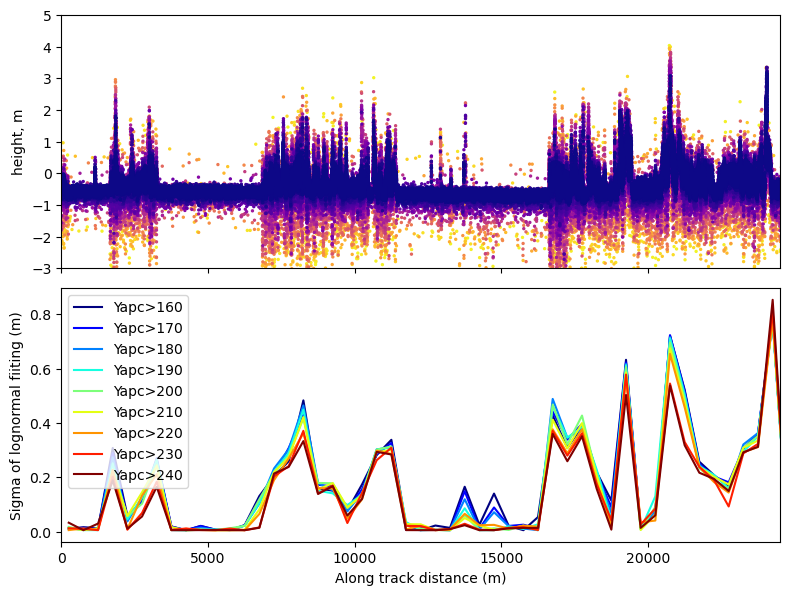

In [185]:
fig, ax = plt.subplots(2,1,figsize=[8,6], sharex = True, height_ratios=[1, 1])

yapc_threshold = 160
signal = D3['yapc_score'] > yapc_threshold

df = D3[signal]

d0=np.min(df['x_atc'])
ii=np.argsort(df['yapc_score'])
sc = ax[0].scatter(df['x_atc'][ii] - d0, df['height_ortho'][ii],2, c=df['yapc_score'][ii],
    vmin=yapc_threshold, vmax=250,cmap='plasma_r')
# fig.colorbar(sc, ax = ax[0], label='YAPC score')
ax[0].set_ylabel('height, m')
ax[0].set_ylim(-3, 5)

for j, yapc_threshold in enumerate(yapc_steps):
    yapc_color = matplotlib.cm.get_cmap('jet')
    rgba = cmap((yapc_threshold - yapc_steps.min())/(yapc_steps.max() - yapc_steps.min()))
    ax[1].plot(xx[j], array_log_sigma[j], color = rgba, label = f"Yapc>{yapc_threshold}")

ax[1].legend()
ax[1].set_ylabel("Sigma of lognormal fiiting (m)")
ax[1].set_xlabel("Along track distance (m)")
ax[1].set_xlim(x_steps[0], x_steps[-1])

plt.tight_layout()
plt.savefig(f"{folder}/Log_sigma_{xbin}.png")
# plt.close()

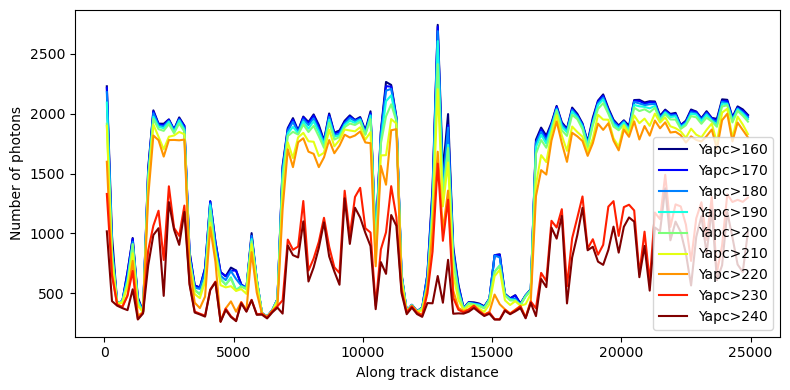

In [178]:
plt.figure(figsize = (8, 4))

for j, yapc_threshold in enumerate(yapc_steps):
    yapc_color = matplotlib.cm.get_cmap('jet')
    rgba = cmap((yapc_threshold - yapc_steps.min())/(yapc_steps.max() - yapc_steps.min()))
    plt.plot(xx[j], array_photon[j], color = rgba, label = f"Yapc>{yapc_threshold}")

plt.legend()
plt.ylabel("Number of photons")
plt.xlabel("Along track distance")
ax[1].set_xlim(x_steps[0], x_steps[-1])

plt.tight_layout()
plt.savefig(f"{folder}/Log_number_{xbin}.png")
# plt.close()

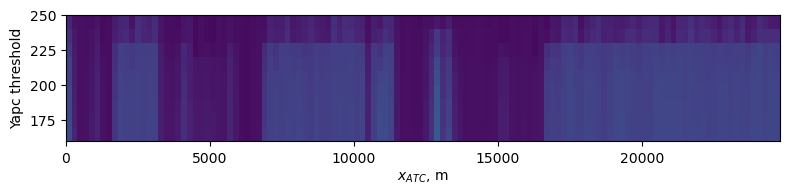

In [142]:
fig, ax = plt.subplots(1,1,figsize=[8,2], sharex = True)

ax.pcolormesh(xx, yy, array_photon, vmax = 10000, vmin = 0.0)
ax.set_xlabel('$x_{ATC}$, m')
ax.set_xlim(x_steps[0], x_steps[-1])
ax.set_ylabel("Yapc threshold")

plt.tight_layout()

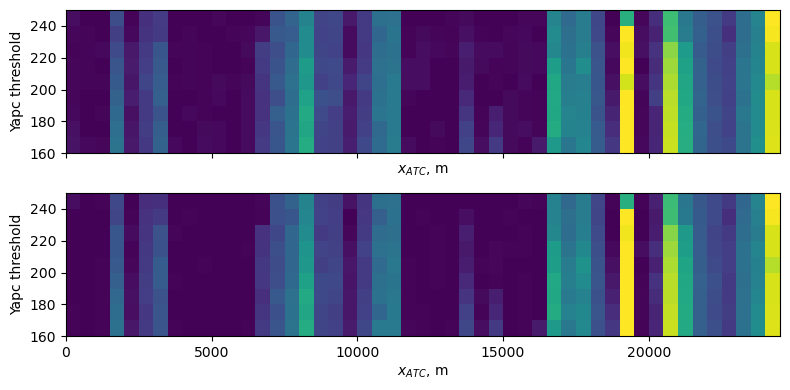

In [78]:
fig, ax = plt.subplots(2,1,figsize=[8,4], sharex = True, height_ratios=[1, 1])

ax[0].pcolormesh(xx, yy, array_log_sigma, vmax = 0.8, vmin = 0.0)
ax[0].set_xlabel('$x_{ATC}$, m')
ax[0].set_xlim(x_steps[0], x_steps[-1])
ax[0].set_ylabel("Yapc threshold")

ax[1].pcolormesh(xx, yy, array_normal_sigma, vmax = 0.8, vmin = 0.0)
ax[1].set_xlabel('$x_{ATC}$, m')
ax[1].set_xlim(x_steps[0], x_steps[-1])
ax[1].set_ylabel("Yapc threshold")

plt.tight_layout()

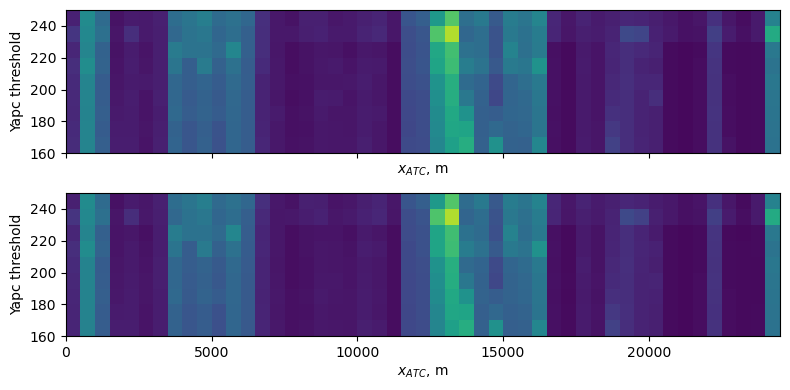

In [62]:
fig, ax = plt.subplots(2,1,figsize=[8,4], sharex = True, height_ratios=[1, 1])

ax[0].pcolormesh(xx, yy, array_log_err, vmax = 0.01, vmin = 0.0)
ax[0].set_xlabel('$x_{ATC}$, m')
ax[0].set_xlim(x_steps[0], x_steps[-1])
ax[0].set_ylabel("Yapc threshold")

ax[1].pcolormesh(xx, yy, array_normal_err, vmax = 0.01, vmin = 0.0)
ax[1].set_xlabel('$x_{ATC}$, m')
ax[1].set_xlim(x_steps[0], x_steps[-1])
ax[1].set_ylabel("Yapc threshold")

plt.tight_layout()